# Data Completion Analysis

## Business Problem

In demand forecasting, if certain items (SKUs) are over-represented in the training data, the model may become biased, learning more from these items and less from under-represented ones. This can lead to poor generalization and unfair performance across departments.

**Objective:**  
- Quantify and visualize the imbalance in data representation per item and department.
- Assess how different stockout filters affect this balance.


## Analysis Roadmap

1. **Baseline Analysis:** Examine item representation when only months with sales are included.
2. **Enhanced Stockout Filter:** Analyze how a new, more inclusive stockout filter changes the data balance.
3. **Comparison & Insights:** Compare both approaches and discuss implications for modeling.


## 1. Baseline Analysis: Months with Sales Only

In this section, we analyze the data by including only (1) items that have been initialized and (2) months where sales occurred.  

**Purpose:** Establish a baseline for item representation before applying any advanced stockout filtering.

*Key Questions:*
- How many observations does each item have?
- How is this distribution skewed across departments?

In [8]:
# Import required libraries
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)

# Now you can import from core if needed
from src.core.clients.bigquery import BigQueryClient

bq_client = BigQueryClient()

sales_query = """
    SELECT 
        tgt.ctx_date_month,
        tgt.ctx_cat_id, 
        tgt.ctx_dept_id, 
        tgt.ctx_item_id,
        tgt.tgt_monthly_sales,
        tgt.tgt_monthly_sales_sum_3_next_months,
        stckt.is_stockout_tgt,
        stckt.is_stockout,
        stckt.stck_indicator_max_days_since_last_sale,
    FROM `porygon-pipelines.walmart_targets_and_filters.target_store_item_monthly` tgt
    LEFT JOIN `porygon-pipelines.walmart_targets_and_filters.stockout_filter` stckt
        ON tgt.ctx_item_id = stckt.ctx_item_id
        AND tgt.ctx_store_id = stckt.ctx_store_id
        AND tgt.ctx_date_month = stckt.ctx_date_month
    LEFT JOIN `porygon-pipelines.walmart_featurestore.item_longevity_features` long
        ON tgt.ctx_item_id = long.ctx_item_id
        AND tgt.ctx_date_month = long.ctx_date_month
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND long.fea_item_longevity_months >=0
        AND tgt_monthly_sales >0
"""


# Extract data
df = bq_client.load_from_query(sales_query)


INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 140865 rows from custom query.


In [9]:
# How many records and unique items?
print(df.shape)
print(df["ctx_item_id"].nunique())

(140865, 9)
3049


In [10]:
# Count observations per item
df_nonstockout_count = df.groupby(["ctx_cat_id", "ctx_dept_id","ctx_item_id"])[["ctx_date_month"]].count().reset_index().rename(
    columns={"ctx_date_month": "count_observations"}
)
df_nonstockout_count["quantiles"] = pd.cut(df_nonstockout_count["count_observations"], bins=[10,20,30,40,50,60], right=True)
df_nonstockout_count.groupby(["quantiles"])[["count_observations"]].sum().reset_index()

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_10794/871572490.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_nonstockout_count.groupby(["quantiles"])[["count_observations"]].sum().reset_index()


,quantiles,count_observations
0,"(10, 20]",3271
1,"(20, 30]",8734
2,"(30, 40]",17981
3,"(40, 50]",24395
4,"(50, 60]",44474


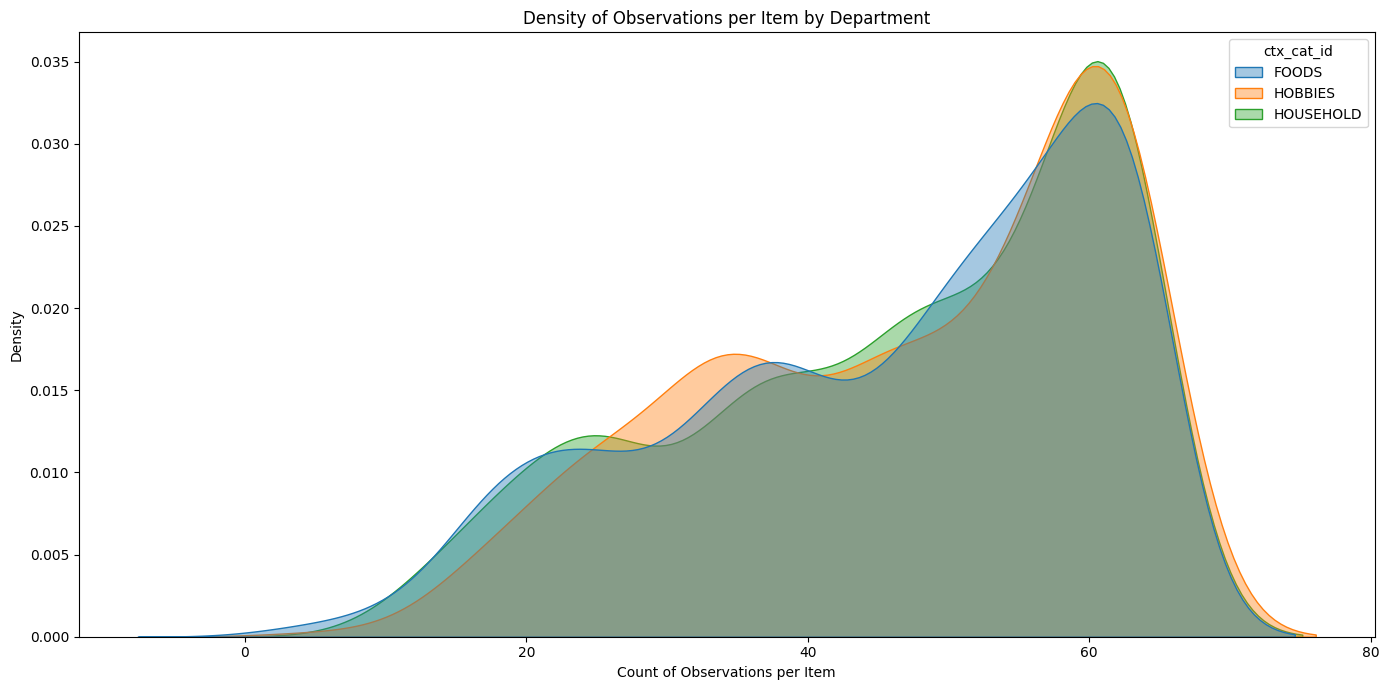

In [11]:
# Visualize the distribution
plt.figure(figsize=(14, 7))
sns.kdeplot(
    data=df_nonstockout_count,
    x="count_observations",
    hue="ctx_cat_id",
    common_norm=False,
    fill=True,
    alpha=0.4
)
plt.xlabel('Count of Observations per Item')
plt.ylabel('Density')
plt.title('Density of Observations per Item by Department')
plt.tight_layout()
plt.show()

In [12]:
# Departmental composition
dept_counts = df_nonstockout_count.groupby(["ctx_dept_id"])["count_observations"].sum()
total = dept_counts.sum()
percentages = (dept_counts/total).reset_index()
print(percentages)

   ctx_dept_id  count_observations
0      FOODS_1            0.073311
1      FOODS_2            0.126582
2      FOODS_3            0.267497
3    HOBBIES_1            0.143023
4    HOBBIES_2            0.045639
5  HOUSEHOLD_1            0.171611
6  HOUSEHOLD_2            0.172335


## 2. Enhanced Stockout Filter

Next I will analyzet the results after applying the new stockout filter. The new stockout filter is more inclusive, allowing for more observations to be included (not considered stockouts) even if they had 0 sales during that month. 

**Purpose:**  
Assess how this new filter changes the data balance and item representation.


# Now with the new stockout filter

In [13]:
# Import required libraries
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)

# Now you can import from core if needed
from src.core.clients.bigquery import BigQueryClient

bq_client = BigQueryClient()

sales_query = """
    SELECT 
        tgt.ctx_date_month,
        tgt.ctx_cat_id, 
        tgt.ctx_dept_id, 
        tgt.ctx_item_id,
        tgt.tgt_monthly_sales,
        tgt.tgt_monthly_sales_sum_3_next_months,
        stckt.is_stockout_tgt,
        stckt.is_stockout,
        stckt.stck_indicator_max_days_since_last_sale,
    FROM `porygon-pipelines.walmart_targets_and_filters.target_store_item_monthly` tgt
    LEFT JOIN `porygon-pipelines.walmart_targets_and_filters.stockout_filter` stckt
        ON tgt.ctx_item_id = stckt.ctx_item_id
        AND tgt.ctx_store_id = stckt.ctx_store_id
        AND tgt.ctx_date_month = stckt.ctx_date_month
    LEFT JOIN `porygon-pipelines.walmart_featurestore.item_longevity_features` long
        ON tgt.ctx_item_id = long.ctx_item_id
        AND tgt.ctx_date_month = long.ctx_date_month
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND stckt.is_stockout_tgt= 0
        AND long.fea_item_longevity_months >=0
"""


# Extract data
df = bq_client.load_from_query(sales_query)


INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 110992 rows from custom query.


In [14]:
# How many records and unique items now?
print(df.shape)
print(df["ctx_item_id"].nunique())

(110992, 9)
3042


In [15]:
# Count observations per item (new filter)
df_nonstockout_count = df.groupby(["ctx_cat_id", "ctx_dept_id","ctx_item_id"])[["ctx_date_month"]].count().reset_index().rename(
    columns={"ctx_date_month": "count_observations"}
)
df_nonstockout_count["quantiles"] = pd.cut(df_nonstockout_count["count_observations"], bins=[10,20,30,40,50,60], right=True)
df_nonstockout_count.groupby(["quantiles"])[["count_observations"]].sum().reset_index()

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_10794/948350542.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_nonstockout_count.groupby(["quantiles"])[["count_observations"]].sum().reset_index()


,quantiles,count_observations
0,"(10, 20]",6840
1,"(20, 30]",13599
2,"(30, 40]",19574
3,"(40, 50]",28357
4,"(50, 60]",28396


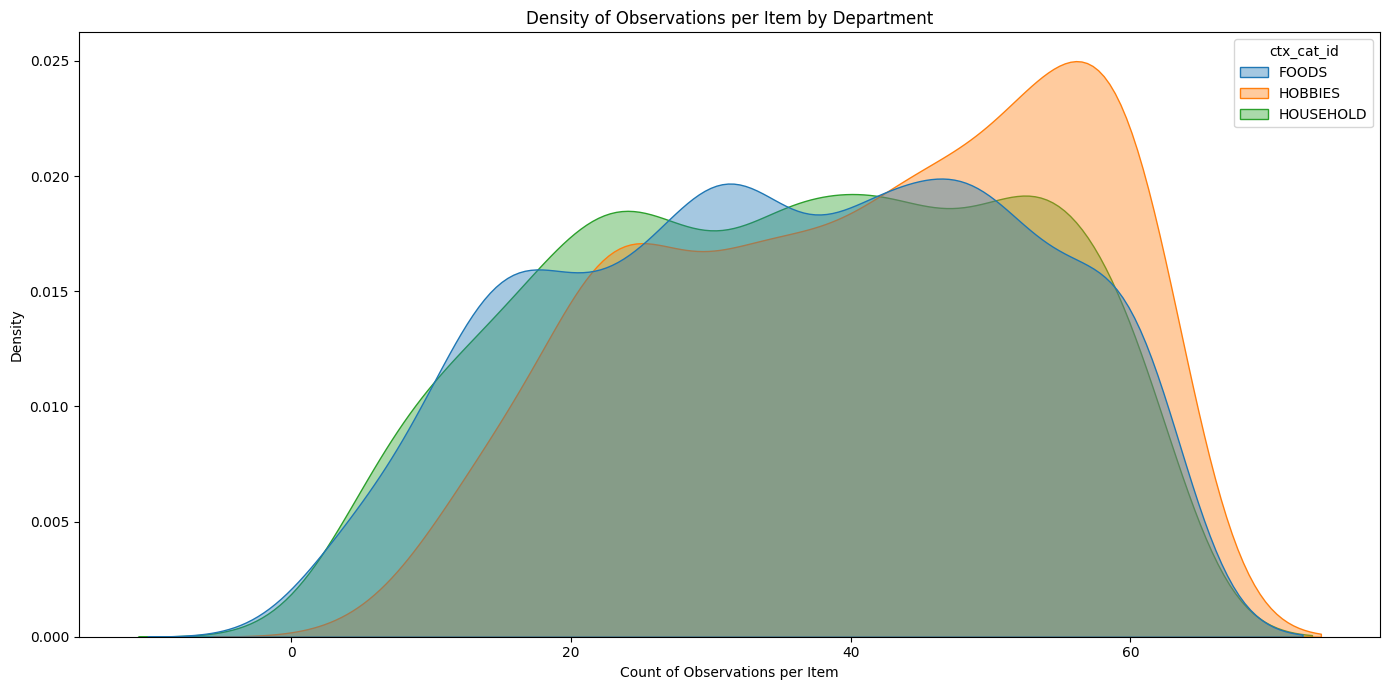

In [16]:
# Visualize the new distribution
plt.figure(figsize=(14, 7))
sns.kdeplot(
    data=df_nonstockout_count,
    x="count_observations",
    hue="ctx_cat_id",
    common_norm=False,
    fill=True,
    alpha=0.4
)
plt.xlabel('Count of Observations per Item')
plt.ylabel('Density')
plt.title('Density of Observations per Item by Department')
plt.tight_layout()
plt.show()

- Notes:
From comparing this graph with the graph before, we can see that the new filter is more inclussinve than filtering for months with zero sales. This enables for more hobbies observations to be taken into account without being considered stockouts. This allows higher data completion per item. 

In [17]:
# Departmental composition (new filter)
dept_counts = df_nonstockout_count.groupby(["ctx_dept_id"])["count_observations"].sum()
total = dept_counts.sum()
percentages = (dept_counts/total).reset_index()
print(percentages)

   ctx_dept_id  count_observations
0      FOODS_1            0.068473
1      FOODS_2            0.116080
2      FOODS_3            0.273921
3    HOBBIES_1            0.163282
4    HOBBIES_2            0.044409
5  HOUSEHOLD_1            0.181139
6  HOUSEHOLD_2            0.152696


## 3. Comparison & Insights

Let’s compare the department composition before and after applying the new stockout filter.

| ctx_dept_id   | Baseline | New Filter |
|---------------|----------|------------|
| FOODS_1       | 0.073    | 0.065      |
| FOODS_2       | 0.126    | 0.120      |
| FOODS_3       | 0.267    | 0.276      |
| HOBBIES_1     | 0.143    | 0.154      |
| HOBBIES_2     | 0.046    | 0.048      |
| HOUSEHOLD_1   | 0.171    | 0.187      |
| HOUSEHOLD_2   | 0.173    | 0.150      |

**Key Takeaways:**
- The new filter is more inclusive, especially for departments with more frequent stockouts (e.g., hobbies).
- The overall composition changes by less than 2 percentage points for all departments.
- The model will still need to handle unbalanced samples. Post-training analysis needs to be performed. 


## 4. Conclusion

- Data imbalance is present and should be considered in modeling.
- The new stockout filter increases data completeness, especially for items with sporadic sales.
- Next steps: Consider re-sampling, weighting, or stratified modeling to address imbalance.
